In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
import csv
import pandas as pd
rng_seed = 42

---

<h1><center>SDSE Final Project (Group 11) <br><br> 4. Random Forest Regression  </center></h1>

---

In this demo, you will be able to understand:
1. Understand how the dataset is cleaned/organized for machine learning algorithms (Random Forest Regression)
2. One-Hot Encoding and Training/Testing Data
3. Compare the Predicted vs Actual through the Random Forest Classifier

## 1) Load the Data 
+ Load the data file `Salary Data.csv` into a Pandas dataframe using [`pd.read_csv`]
+ Save the column headers corresponding to feature names (all except the `Salary`) to the variable `feature_names`

In [52]:
rawdata = pd.read_csv('Salary Data.csv')
feature_names = rawdata.columns[:-1]
print(feature_names)
rawdata

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience'], dtype='object')


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


## 2) Data Cleaning
+ Perform the same data cleaning process but in one box of code.
    + Contains removing null values and classifying releveant objects as binary, multiclass values.  

In [53]:
education_map = []
for value in rawdata.loc[:, 'Education Level']:
    if value == "Bachelor's":
        education_map.append(0)
    elif value == "Master's":
        education_map.append(1)
    elif value == "PhD":
        education_map.append(2)
    else:
        education_map.append(-1)

gender_map = []
for value in rawdata.loc[:, 'Gender']:
    if value == "Female":
        gender_map.append(0)
    elif value == "Male":
        gender_map.append(1)
    else:
        gender_map.append(-1)

rawdata['Education Level'] = education_map
rawdata['Gender'] = gender_map

rawdata = rawdata.drop(rawdata[rawdata['Education Level'] == -1].index)
rawdata = rawdata.drop(rawdata[rawdata['Gender'] == -1].index)

rawdata

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,1,0,Software Engineer,5.0,90000.0
1,28.0,0,1,Data Analyst,3.0,65000.0
2,45.0,1,2,Senior Manager,15.0,150000.0
3,36.0,0,0,Sales Associate,7.0,60000.0
4,52.0,1,1,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,0,0,Senior Marketing Analyst,8.0,85000.0
371,43.0,1,1,Director of Operations,19.0,170000.0
372,29.0,0,0,Junior Project Manager,2.0,40000.0
373,34.0,1,0,Senior Operations Coordinator,7.0,90000.0


## 3) One-Hot Encoding
+ Represent categorical variables as binary vectors
    + Useful for machine learning algorithms to improve salary predictions
+ Eliminates ordinal relationship between categories and prevents the algorithm from misinterpreting the data
+ Each element has its own row/column and labeled as 1.0 if True and 0.0 if False

In [54]:
from sklearn.preprocessing import OneHotEncoder
# Function to determine the field from job title
def get_field(job_title):
    if 'Sales' in job_title:
        return 'Sales'
    elif 'Marketing' in job_title:
        return 'Marketing'
    elif ('Finance' or 'Business') in job_title:
        return 'Finance'
    elif ('HR' or 'Human Resources' or 'Recruiter') in job_title:
        return 'Admin'
    elif ('Engineer' or 'Software' or 'Web') in job_title:
        return 'Engineering'
    elif 'Operations' in job_title:
        return 'Operations'
    elif ('Scientist' or 'Researcher') in job_title:
        return 'Researcher'
    elif ('CEO' or 'Chief' or 'VP' or 'Vice President') in job_title:
        return 'Executive'
    else:
        return 'Other'

# Function to determine seniority from job title
def get_seniority(job_title):
    if 'Manager' in job_title:
        return 'Manager'
    elif 'Junior' in job_title:
        return 'Junior'
    elif 'Senior' in job_title:
        return 'Senior'
    elif 'Coordinator' in job_title:
        return 'Coordinator'
    elif 'Director' in job_title:
        return 'Director'
    elif ('CEO' or 'Chief' or 'VP' or 'Vice President') in job_title:
        return 'Executive'
    else:
        return 'None'

# Apply the functions to create new 'Field' and 'Seniority' columns
rawdata['Field'] = rawdata['Job Title'].apply(get_field)
rawdata['Seniority'] = rawdata['Job Title'].apply(get_seniority)

# Extract the categorical columns
categorical_columns = ['Job Title', 'Field', 'Seniority']
categorical_data = rawdata[categorical_columns]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the categorical features
encoded_data = encoder.fit_transform(categorical_data)

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the new DataFrame with the original DataFrame
df_encoded = pd.concat([rawdata, encoded_df], axis=1)

# Display the result
df_encoded

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Field,Seniority,Job Title_Accountant,Job Title_Administrative Assistant,...,Field_Operations,Field_Other,Field_Researcher,Field_Sales,Seniority_Director,Seniority_Executive,Seniority_Junior,Seniority_Manager,Seniority_None,Seniority_Senior
0,32.0,1.0,0.0,Software Engineer,5.0,90000.0,Engineering,None,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28.0,0.0,1.0,Data Analyst,3.0,65000.0,Other,None,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,45.0,1.0,2.0,Senior Manager,15.0,150000.0,Other,Manager,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,36.0,0.0,0.0,Sales Associate,7.0,60000.0,Sales,None,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,52.0,1.0,1.0,Director,20.0,200000.0,Other,Director,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,29.0,0.0,0.0,Junior Project Manager,2.0,40000.0,Other,Manager,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
373,34.0,1.0,0.0,Senior Operations Coordinator,7.0,90000.0,Operations,Senior,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,44.0,0.0,2.0,Senior Business Analyst,15.0,150000.0,Other,Senior,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 4) Remove null values and other unnecessary columns
+ We do not need 'Job Title' 'Field' or 'Seniority' as we have already made classifications for all of them.
+ There are missing values (NaN), so simply use the .dropna() function to remove them.
+ Note: Final shape of the dataset should be 371 rows by 192 columns.

In [55]:
df_encoded_filtered = df_encoded.drop(columns= ['Job Title', 'Field', 'Seniority'])
df_encoded_filtered = df_encoded_filtered.dropna(how = 'any')
df_encoded_filtered

,Age,Gender,Education Level,Years of Experience,Salary,Job Title_Accountant,Job Title_Administrative Assistant,Job Title_Business Analyst,Job Title_Business Development Manager,Job Title_Business Intelligence Analyst,...,Field_Operations,Field_Other,Field_Researcher,Field_Sales,Seniority_Director,Seniority_Executive,Seniority_Junior,Seniority_Manager,Seniority_None,Seniority_Senior
0,32.0,1.0,0.0,5.0,90000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28.0,0.0,1.0,3.0,65000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,45.0,1.0,2.0,15.0,150000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,36.0,0.0,0.0,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,52.0,1.0,1.0,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,44.0,0.0,2.0,16.0,160000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
369,33.0,1.0,0.0,4.0,60000.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
370,35.0,0.0,0.0,8.0,85000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
371,43.0,1.0,1.0,19.0,170000.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5) Extract the test dataset
+ Split 'df_encoded_filtered' into training and testing parts. Keep 80% for training and 20% for testing. Always pass `random_state=rng_seed` to `train_test_split` so that the result is repeatable.

In [56]:
from sklearn.model_selection import train_test_split
Y = df_encoded_filtered['Salary']
X = df_encoded_filtered.drop(columns='Salary')
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size = .2, random_state = rng_seed)

## 6) Random Forest 

In [57]:
# Create a Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 15, oob_score = True, random_state = rng_seed)
model.fit(Xtrain, ytrain)

RandomForestRegressor(n_estimators=15, oob_score=True, random_state=42)

## 7) Actual Prediction of Salary

In [58]:
ypred = model.predict(Xtest)

pred_data = pd.DataFrame(Xtest)
pred_data['Salary'] = ytest
pred_data['Pred_Salary'] = ypred

## 8) Comparison of Predicted vs Actual Salary
+ Includes OOB (out of bag score) - performance metric for Random Forests (ensemble model) and other relevant metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE)

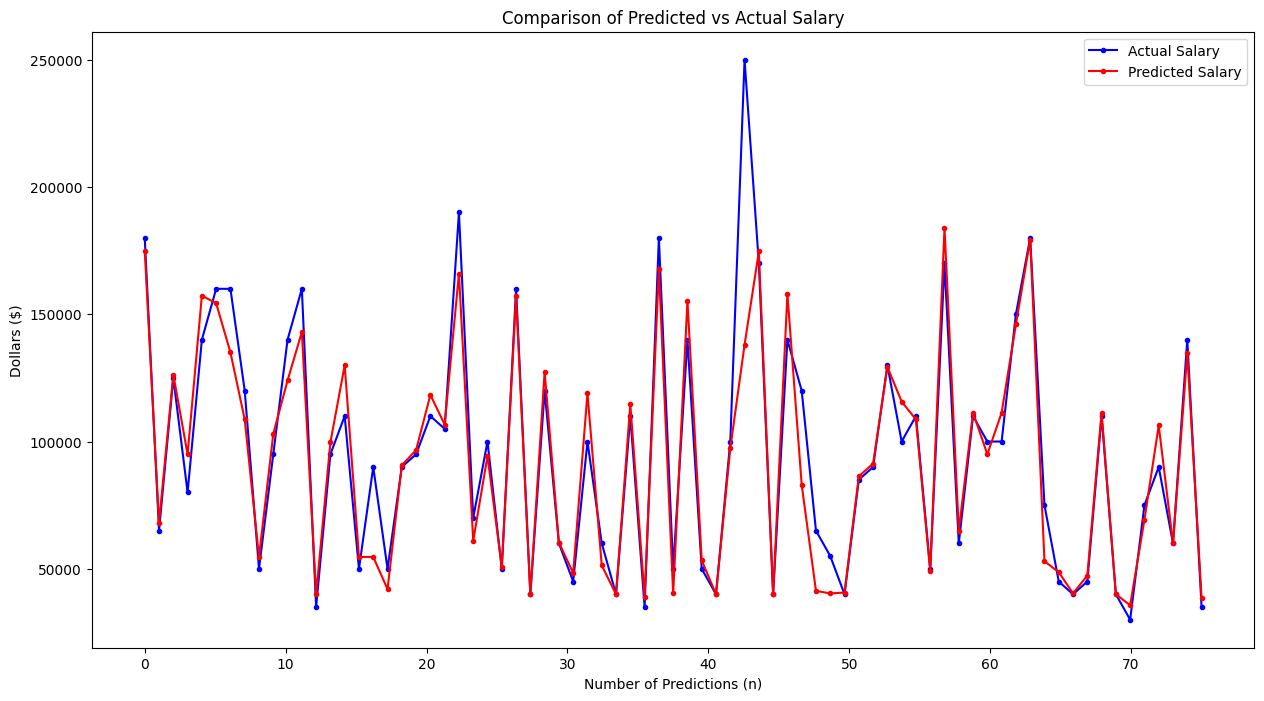

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
X = np.linspace(0,len(ytest),len(ytest))
ax.plot(X, ytest,'b.', linestyle='-', label='Actual Salary')
ax.plot(X, ypred,'r.', linestyle='-', label='Predicted Salary')
ax.set_title('Comparison of Predicted vs Actual Salary')

ax.set_xlabel('Number of Predictions (n)')
ax.set_ylabel('Dollars ($)')

ax.legend(fontsize=10)

In [60]:
# Calculations for determining the metrics
from sklearn import metrics
print('MAE: ', metrics.mean_absolute_error(ytest,ypred) )
print('MSE: ', metrics.mean_squared_error(ytest,ypred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print('MAPE: ', metrics.mean_absolute_percentage_error(ytest,ypred))

MAE:  9226.666666666666
MSE:  295031111.1111111
RMSE: 17176.46969289997
MAPE:  0.09131026739495261


Text(0, 0.5, 'Salary Actual ($)')

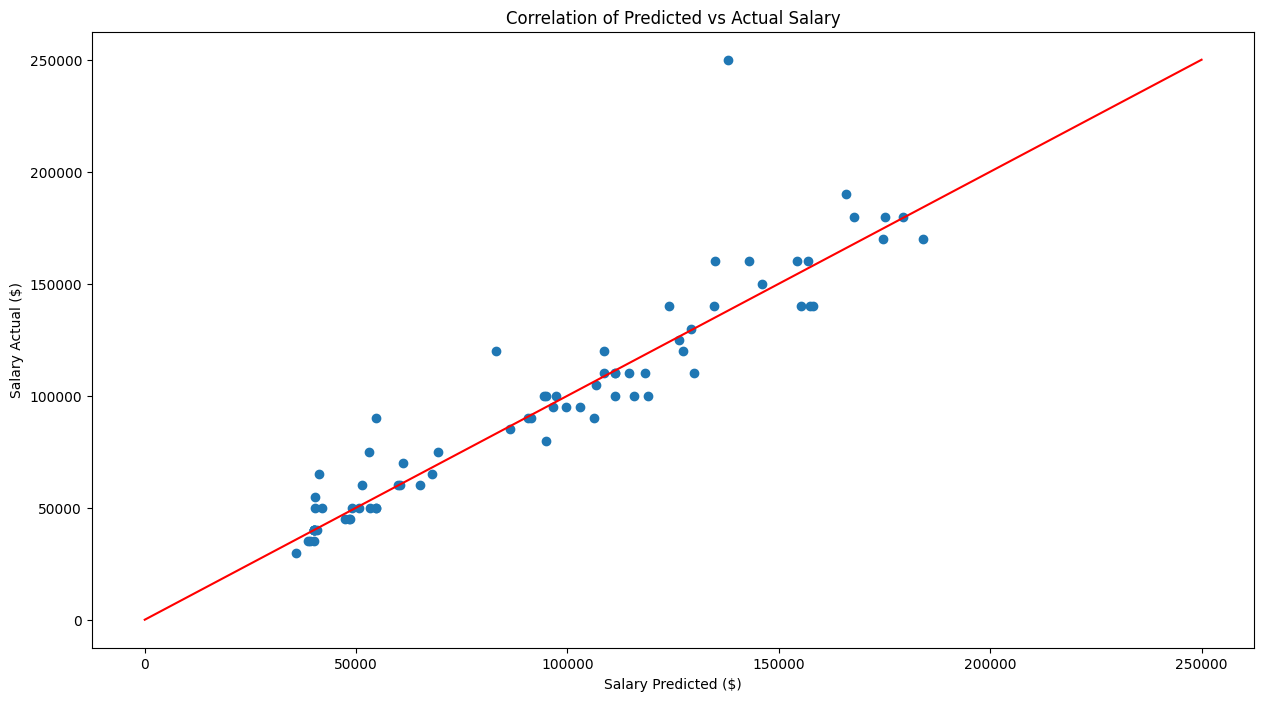

In [61]:
# Another form of comparing Predicted vs Actual Salary (Scatter plot)
fig2, ax2 = plt.subplots(figsize=(15,8))
ax2.scatter(ypred,ytest)
ax2.plot(np.linspace(0,250000),np.linspace(0,250000), color = 'red')
ax2.set_title('Correlation of Predicted vs Actual Salary')
ax2.set_xlabel('Salary Predicted ($)')
ax2.set_ylabel('Salary Actual ($)')
